In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
from pathlib import Path

actions = []

video_file_path = '/Users/sunukkim/PycharmProjects/sign_language_AIVision/videos'
for file in Path(video_file_path).iterdir():
    print(file.stem)
    actions.append(file.stem)

마라톤_concat
노래_concat
할머니_concat
누나_concat
이십육_concat
테니스_concat
이십이_concat
귀엽다_concat
오빠_concat
조용하다_concat
똑똑하다_concat
수다스럽다_concat
이십_concat
형_concat
권투_concat
친부_concat
이십오_concat
여동생_concat
이십칠_concat
이십삼_concat
이십사_concat
할아버지_concat
이십일_concat
솔직하다_concat
친모_concat
수영_concat
이십팔_concat
야구_concat
이십구_concat
낚시_concat


In [3]:
data = np.concatenate([
    np.load('dataset/seq_솔직하다_concat_1683125186.npy'),
    np.load('dataset/seq_이십오_concat_1683125186.npy'),
    np.load('dataset/seq_이십사_concat_1683125186.npy'),
    np.load('dataset/seq_오빠_concat_1683125186.npy'),
    np.load('dataset/seq_할아버지_concat_1683125186.npy'),
    np.load('dataset/seq_이십일_concat_1683125186.npy'),
    np.load('dataset/seq_마라톤_concat_1683125186.npy'),
    np.load('dataset/seq_테니스_concat_1683125186.npy'),
    np.load('dataset/seq_조용하다_concat_1683125186.npy'),
    np.load('dataset/seq_이십팔_concat_1683125186.npy'),
    np.load('dataset/seq_수영_concat_1683125186.npy'),
    np.load('dataset/seq_이십칠_concat_1683125186.npy'),
    np.load('dataset/seq_이십구_concat_1683125186.npy'),
    np.load('dataset/seq_형_concat_1683125186.npy'),
    np.load('dataset/seq_낚시_concat_1683125186.npy'),
    np.load('dataset/seq_똑똑하다_concat_1683125186.npy'),
    np.load('dataset/seq_이십육_concat_1683125186.npy'),
    np.load('dataset/seq_수다스럽다_concat_1683125186.npy'),
    np.load('dataset/seq_할머니_concat_1683125186.npy'),
    np.load('dataset/seq_귀엽다_concat_1683125186.npy'),
    np.load('dataset/seq_야구_concat_1683125186.npy'),
    np.load('dataset/seq_친부_concat_1683125186.npy'),
    np.load('dataset/seq_친모_concat_1683125186.npy'),
    np.load('dataset/seq_이십이_concat_1683125186.npy'),
    np.load('dataset/seq_누나_concat_1683125186.npy'),
    np.load('dataset/seq_이십_concat_1683125186.npy'),
    np.load('dataset/seq_권투_concat_1683125186.npy'),
    np.load('dataset/seq_여동생_concat_1683125186.npy'),
    np.load('dataset/seq_노래_concat_1683125186.npy'),
    np.load('dataset/seq_이십삼_1681655684.npy')
], axis=0)

data.shape

(51200, 30, 100)

In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(51200, 30, 99)
(51200,)


In [5]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(51200, 30)

In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(46080, 30, 99) (46080, 30)
(5120, 30, 99) (5120, 30)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=x_train.shape[1:]),
    MaxPooling1D(3),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28, 64)            19072     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 9, 64)             33024     
_________________________________________________________________
dropout (Dropout)            (None, 9, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                9

2023-05-04 00:22:06.458776: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 00:22:06.459363: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('models/second_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Train on 46080 samples, validate on 5120 samples
Epoch 1/50
46016/46080 [============================>.] - ETA: 0s - loss: 2.4823 - acc: 0.2639
Epoch 00001: val_acc improved from -inf to 0.54688, saving model to models/second_model.h5
46080/46080 [==============================] - 72s 2ms/sample - loss: 2.4812 - acc: 0.2641 - val_loss: 1.3376 - val_acc: 0.5469
Epoch 2/50
46016/46080 [============================>.] - ETA: 0s - loss: 1.2313 - acc: 0.5799
Epoch 00002: val_acc improved from 0.54688 to 0.68242, saving model to models/second_model.h5
46080/46080 [==============================] - 70s 2ms/sample - loss: 1.2314 - acc: 0.5800 - val_loss: 0.9002 - val_acc: 0.6824
Epoch 3/50
46048/46080 [============================>.] - ETA: 0s - loss: 0.8258 - acc: 0.7103
Epoch 00003: val_acc improved from 0.68242 to 0.80371, saving model to models/second_model.h5
46080/46080 [==============================] - 114s 2ms/sample - loss: 0.8258 - acc: 0.7102 - val_loss: 0.5783 - val_acc: 0.8037
Ep

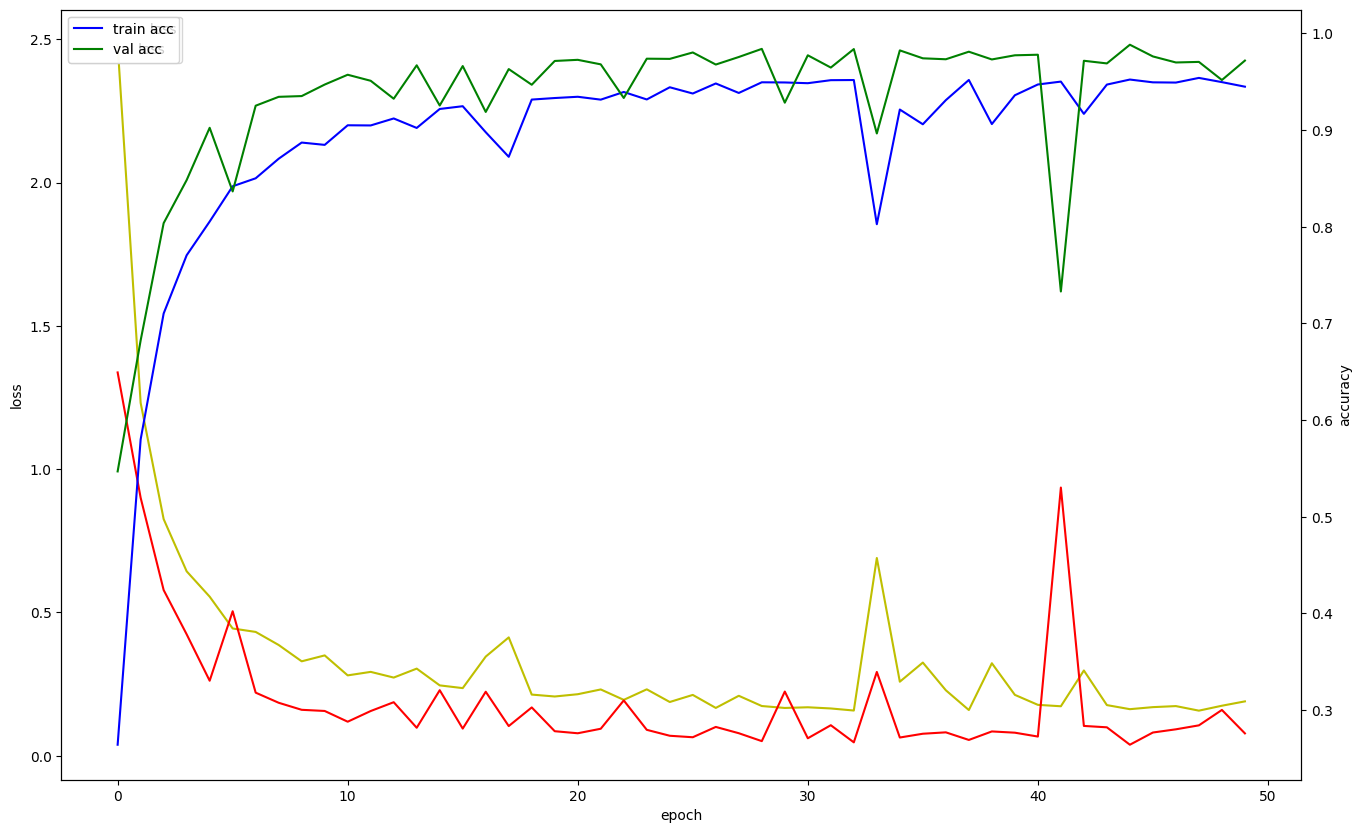

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/second_model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[4701,  245],
        [ 168,    6]],

       [[4931,   18],
        [ 167,    4]],

       [[4939,   11],
        [ 170,    0]],

       [[4851,  107],
        [ 151,   11]],

       [[4838,  113],
        [ 169,    0]],

       [[4954,    2],
        [ 164,    0]],

       [[4812,  138],
        [ 170,    0]],

       [[4781,  136],
        [ 199,    4]],

       [[4666,  301],
        [ 144,    9]],

       [[4904,   36],
        [ 180,    0]],

       [[4731,  201],
        [ 166,   22]],

       [[4950,    3],
        [ 167,    0]],

       [[4945,   17],
        [ 145,   13]],

       [[4887,   67],
        [  81,   85]],

       [[4773,  190],
        [ 154,    3]],

       [[4781,  141],
        [ 198,    0]],

       [[4939,   16],
        [ 164,    1]],

       [[4748,  201],
        [ 171,    0]],

       [[4801,  137],
        [ 182,    0]],

       [[4776,  344],
        [   0,    0]],

       [[4854,   95],
        [ 171,    0]],

       [[4861,  108],
        [ 14